In [1]:
import cv2
import datetime as dt

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from keras import models, layers, optimizers
from keras.layers import Input, Dense
from keras.models import Model

from pathlib import Path

from vis.utils import utils
import keras.backend as K

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
weights = Path('C:/Users/npurk/Desktop/VAE/monkey_model.h5')
train_dir = Path('C:/Users/npurk/Desktop/VAE/training/')
test_dir = Path('C:/Users/npurk/Desktop/VAE/validation/')

In [3]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("C:/Users/npurk/Desktop/VAE/monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


(367, 550, 3)


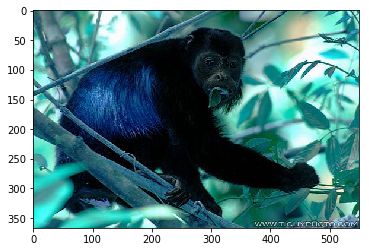

In [4]:
img = cv2.imread('C:/Users/npurk/Desktop/VAE/training/n0018.jpg')
print(img.shape)
plt.imshow(img);

In [5]:
import os

all_monkeys = []
for image in os.listdir(train_dir):
    try:
        monkey = utils.load_img(('C:/Users/npurk/Desktop/VAE/training/' + image), target_size=(64,64))
        all_monkeys.append(monkey)
    except Exception as e:
        pass
    
print('Recovered data format:', type(all_monkeys))    
print('Number of monkey images:', len(all_monkeys))
    

D:\Anaconda\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Recovered data format: <class 'list'>
Number of monkey images: 1094


In [6]:
# Make into array
all_monkeys = np.asarray(all_monkeys)
print('Shape of array:', all_monkeys.shape)

# Normalize pixel values
all_monkeys = all_monkeys.astype('float32') / 255.



Shape of array: (1094, 64, 64, 3)


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train , y_test = train_test_split(all_monkeys, all_monkeys, test_size=0.2, random_state=42)

In [54]:
# Check shape

x_train.shape, x_test.shape

((875, 64, 64, 3), (219, 64, 64, 3))

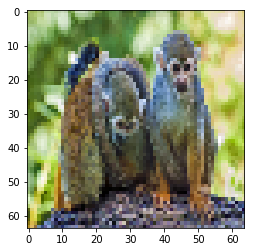

In [9]:
# Print example from training set
plt.imshow(x_train[3])


In [29]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

# Input Placeholder
input_img = Input(shape=(64, 64, 3))  # adapt this if using `channels_first` image data format

# Encoder part
l1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
l2 = MaxPooling2D((2, 2), padding='same')(l1)
l3 = Conv2D(16, (3, 3), activation='relu', padding='same')(l2)

# Latent Space, with dimension (None, 32, 32, 16)
encoded = MaxPooling2D((1,1), padding='same')(l3) 


# Decoder Part
l8 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
l9 = UpSampling2D((2, 2))(l8)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(l9)

#Initialize model
autoencoder = Model(input_img, decoded)

# Print summary
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 64, 64, 16)        0         
__________

In [30]:
# Check shape of a layer
import keras
keras.backend.int_shape(encoded)

(None, 32, 32, 16)

In [31]:
# Compile model
autoencoder.compile(optimizer='adam', loss='mse')

In [32]:
# Initiate training session
autoencoder.fit(x_train, x_train, epochs=50, batch_size=20,
               shuffle=True, verbose=1)


Epoch 1/50
875/875 [==============================] - 7s 8ms/step - loss: 0.0462
Epoch 2/50
875/875 [==============================] - 6s 7ms/step - loss: 0.0173
Epoch 3/50
875/875 [==============================] - 7s 9ms/step - loss: 0.0133
Epoch 4/50
875/875 [==============================] - 8s 9ms/step - loss: 0.0116
Epoch 5/50
875/875 [==============================] - 8s 9ms/step - loss: 0.0104
Epoch 6/50
875/875 [==============================] - 8s 9ms/step - loss: 0.0096
Epoch 7/50
875/875 [==============================] - 8s 9ms/step - loss: 0.0091
Epoch 8/50
875/875 [==============================] - 8s 9ms/step - loss: 0.0086
Epoch 9/50
875/875 [==============================] - 6s 7ms/step - loss: 0.0083
Epoch 10/50
875/875 [==============================] - 6s 7ms/step - loss: 0.0080
Epoch 11/50
875/875 [==============================] - 8s 9ms/step - loss: 0.0078
Epoch 12/50
875/875 [==============================] - 8s 9ms/step - loss: 0.0075
Epoch 13/50
875/875 [====

In [49]:
def compare_outputs(x_test, decoded_imgs=None, n=10):
    plt.figure(figsize=(22, 5))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(64,64,3))

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i+ 1 +n)
            plt.imshow(decoded_imgs[i].reshape(64,64,3))

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

Upper row: Input image provided 
Bottom row: Decoded output generated


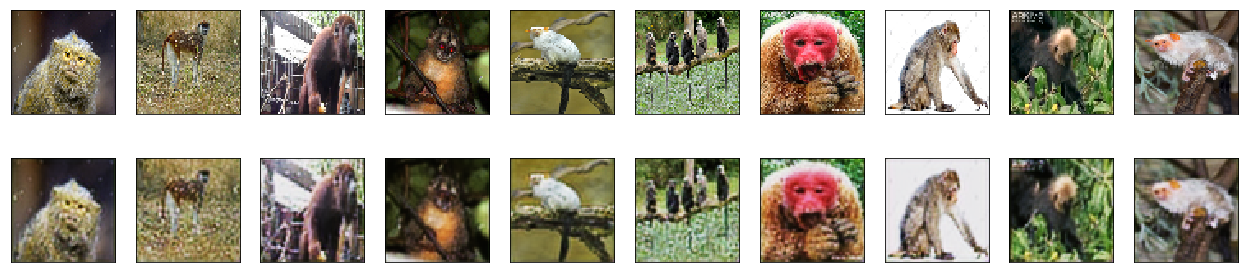

In [50]:
decoded_imgs = autoencoder.predict(x_test)
print('Upper row: Input image provided \nBottom row: Decoded output generated')
compare_outputs(x_test, decoded_imgs)

In [53]:
#autoencoder.save('C:/Users/npurk/Desktop/AE/CNN_AE.h5py')



In [22]:
#from keras.models import load_model

In [23]:
#autoencoder = load_model('C:/Users/npurk/Desktop/AE/CNN_AE.h5py')